In [15]:
import numpy as np
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [16]:
df = pd.read_csv("train_imputed.csv")
df['Datetime'] = pd.to_datetime(df['Datetime'], errors='coerce')

# Set Datetime as index
df.set_index('Datetime', inplace=True)
df.head()


,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
Datetime,,,,,,,,,,,,,,,,,,,
2018-01-01 06:20:00+00:00,26.212347,28.696304,43.523110,-1.016804,3.564672,3.557032,60.640646,56.706837,895.774625,70.645030,69.722514,37.716510,38.544344,252.00,3.976499,8.059783,-592.484749,252.00,3.042750
2018-01-01 06:40:00+00:00,59.632658,29.052567,43.366961,-1.010366,3.566413,3.575760,60.926373,56.792146,887.727480,70.992927,70.237055,37.498873,39.204888,255.00,11.091660,7.921004,240.798588,255.00,3.424814
2018-01-01 06:50:00+00:00,40.889650,28.984758,43.389995,-1.001769,3.560169,3.568837,60.803980,56.768909,839.111531,70.676037,69.777269,37.274875,39.066075,264.75,4.234497,7.558559,-253.149513,264.75,3.507172
2018-01-01 10:40:00+00:00,34.398111,30.282058,43.287790,-1.012153,3.579531,3.589212,62.225082,57.189366,885.813885,67.051610,66.178862,38.235050,41.148748,283.75,5.347792,7.904770,264.637148,283.75,3.442212
2018-01-01 12:00:00+00:00,29.797653,29.333519,43.537917,-1.005509,3.564509,3.581037,60.751892,56.872258,885.967756,70.301019,69.496685,36.825421,39.725250,274.00,6.022326,7.905989,-442.291251,274.00,3.031363


# Formatting the dataset into days

In [17]:
# Define column groups
sum_cols = ['ActivePower', 'ReactivePower']
mode_cols = ['TurbineStatus']
median_cols = [col for col in df.columns if col not in sum_cols and col not in mode_cols]

# Create a safe mode function that won't fail if mode is empty
def safe_mode(x):
    mode_result = x.mode()
    if len(mode_result) > 0:
        return mode_result[0]
    elif len(x) > 0:
        # Return first value if no mode exists
        return x.iloc[0]
    else:
        # Return None if series is empty
        return None

# Define complete aggregation rules
rules = {
    **{col: 'sum' for col in sum_cols},
    **{col: 'mean' for col in median_cols},
    **{col: safe_mode for col in mode_cols},
}

# Make a copy of the dataframe
df_daily = df.copy()

# Apply aggregation with rules
df_daily = df_daily.resample('D').agg(rules)

# Fill any remaining NaN values in mean columns
for col in median_cols:
    if df_daily[col].isna().any():
        # Forward fill, then backward fill to handle any remaining NaNs
        df_daily[col] = df_daily[col].fillna(method='ffill').fillna(method='bfill')

# Reset timezone if needed
df_daily.index = df_daily.index.tz_localize(None)
df_daily.head()

,ActivePower,ReactivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,RotorRPM,WindDirection,WindSpeed,TurbineStatus
Datetime,,,,,,,,,,,,,,,,,,,
2018-01-01,24178.923956,4887.431384,25.537023,42.450180,-1.012626,3.564939,3.564878,64.350188,57.043266,1091.250018,72.010994,71.237266,35.115207,36.039641,276.727612,9.786767,276.727612,5.234498,-1030.522115
2018-01-02,40070.788083,8089.181950,25.356903,42.744889,-0.904183,3.563333,3.564565,64.680898,57.141338,1141.820868,72.661137,71.912245,35.331589,35.787380,274.105603,10.245145,274.105603,5.344286,-883.317484
2018-01-03,40129.409441,8090.072351,24.487208,41.897315,-0.831959,3.565324,3.562921,64.501563,57.228393,1122.873832,73.261184,72.517214,34.498734,34.826119,286.369130,10.078019,286.369130,5.285910,-1022.566873
2018-01-04,47287.251399,9498.206651,24.975148,42.258727,-0.945623,3.564528,3.562658,64.090940,57.070664,1091.827457,72.141436,71.377444,34.979371,35.303371,284.445471,9.798326,284.445471,5.095768,-1053.301415
2018-01-05,30015.577400,6041.641568,23.549267,41.797483,-0.987920,3.563545,3.562715,63.784329,56.985858,1062.317034,73.037907,72.274507,34.066449,33.866121,292.013293,9.537334,292.013293,4.953079,-1052.665269


In [18]:
df_daily.isnull().sum()

ActivePower                      0
ReactivePower                    0
AmbientTemperatue                0
BearingShaftTemperature          0
Blade1PitchAngle                 0
Blade2PitchAngle                 0
Blade3PitchAngle                 0
GearboxBearingTemperature        0
GearboxOilTemperature            0
GeneratorRPM                     0
GeneratorWinding1Temperature     0
GeneratorWinding2Temperature     0
HubTemperature                   0
MainBoxTemperature               0
NacellePosition                  0
RotorRPM                         0
WindDirection                    0
WindSpeed                        0
TurbineStatus                   72
dtype: int64

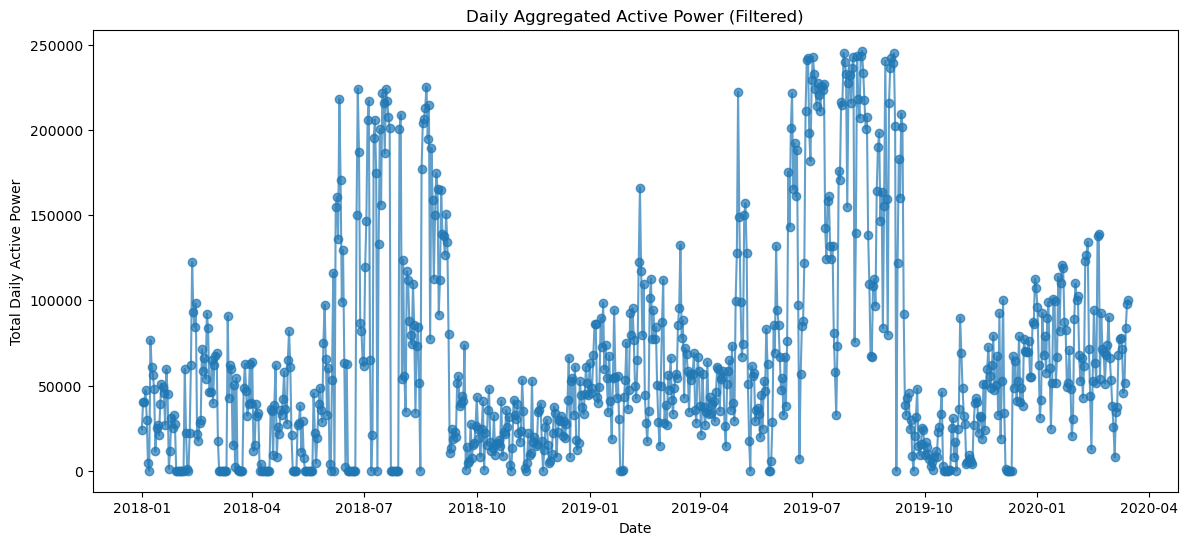

In [19]:
# Plot the adjusted daily ActivePower after filtering
plt.figure(figsize=(14, 6))
plt.plot(df_daily.index, df_daily.ActivePower, marker='o', linestyle='-', alpha=0.7)
plt.title('Daily Aggregated Active Power (Filtered)')
plt.xlabel('Date')
plt.ylabel('Total Daily Active Power')
plt.show()

## Prophet 

In [20]:
# Split test and train sets
train_size = int(len(df_daily) * 0.85) 
train, test = df_daily.iloc[:train_size], df_daily.iloc[train_size:]

In [21]:
# Create dataset
df_prophet = train['ActivePower'].reset_index()
df_prophet.rename(columns={'Datetime': 'ds', 'ActivePower': 'y'}, inplace=True)

# Ensure ds is datetime type without timezone
if df_prophet['ds'].dt.tz is not None:
    df_prophet['ds'] = df_prophet['ds'].dt.tz_localize(None)

df_prophet.head()

,ds,y
0,2018-01-01,24178.923956
1,2018-01-02,40070.788083
2,2018-01-03,40129.409441
3,2018-01-04,47287.251399
4,2018-01-05,30015.577400


In [26]:
model_prophet = Prophet(
    changepoint_prior_scale=0.01,
    yearly_seasonality=True, 
    weekly_seasonality=True,  
    daily_seasonality=True
)
# model_prophet.add_seasonality(name='yearly', period=365, fourier_order=15)
model_prophet.add_seasonality(name='quarterly', period=91, fourier_order=20)
# model_prophet.add_seasonality(name='weekly', period=7, fourier_order=6)
model_prophet.fit(df_prophet)

future = model_prophet.make_future_dataframe(periods=len(test) + 15, freq='D')

# Forecast
forecast = model_prophet.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(15)

20:31:33 - cmdstanpy - INFO - Chain [1] start processing
20:31:33 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
805,2020-03-16,90843.012885,36571.143927,149153.459229
806,2020-03-17,90796.231415,32128.803356,141274.293626
807,2020-03-18,88099.915475,34851.184412,141678.070043
808,2020-03-19,78040.539778,28964.731104,131113.569142
809,2020-03-20,61842.988241,5691.717168,114471.545249
810,2020-03-21,58967.282226,2662.619367,113267.963415
811,2020-03-22,68035.058030,16292.633695,120833.972053
812,2020-03-23,98796.291461,45040.463784,154651.237104
813,2020-03-24,116579.323342,61420.330031,165229.757057
814,2020-03-25,116094.037905,55073.893841,168076.559448


In [24]:
y_true = test['ActivePower'].values
y_pred = forecast['yhat'].iloc[:len(test)].values

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
rmse

48202.18874364393